The objective is to build a recommender system for movies, using TF-IDF method.

A dataset containing titles, genres, keywords,synopsis etc. will be downloaded.
https://www.kaggle.com/tmdb/tmdb-movie-metadata


A query will have the title of a movie, which must be existing in the dataset, and top 5 recommendations must be provided based on the given movie.

Importing all relevant libraries :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


To download the requisite dataset :

In [ ]:
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv


Reading the file as a dataframe :

In [3]:
moviedata=pd.read_csv('tmdb_5000_movies.csv')


In [4]:
moviedata.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


It is observed that some of the columns store values as json strings.

Checking the first row of data, 

In [5]:
row1=moviedata.iloc[0]
row1

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [6]:
row1['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

This is a list of json strings, and the useful attribute here is "name", which contains the names of the genres.

In [7]:
row1['keywords']


'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

Even in this case, the only attribute required is "name".

We need to convert this json string to a usable format.
json.loads() method can be used to parse a valid JSON string and
convert it into a Python Dictionary, as implemented here

In [8]:
x1=json.loads(row1['genres'])
x1

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

We need to convert this dictionary/json to a single string of text, such that it is appropriate for TFIDF.

In [9]:
" ".join("".join(x["name"].split()) for x in x1)

'Action Adventure Fantasy ScienceFiction'

Taking the "name" key of every entry, split it on whitespace, 
and join it back together using empty string '' (for cases like Science Fiction made to ScienceFiction)

This will be done for all genre "name" elements, which are then joined by the final outer join() function, 
concatenating all genre tokens with a single whitespace between them.

We need to implement this for all genres and keywords of all rows over the entire dataset, 
implemented by :

In [10]:
def genres_and_keywords_to_string(row):
    genres=json.loads(row['genres'])
    genres= " ".join("".join(x["name"].split()) for x in genres)
    
    keywords=json.loads(row['keywords'])
    keywords=" ".join("".join(y["name"].split()) for y in keywords)
    
    combinedstring="%s %s" %(genres,keywords)
    
    return combinedstring
    
    

This function converts the useful tokens from each json row's genres and keywords to a single string

*It must be clear at this point that we are considering only the genres and keywords data to compare between the movies 
in the scope of this program.

Now, we can apply this function to each row, and generate a new column named string

In [11]:
moviedata['string']=moviedata.apply(genres_and_keywords_to_string,axis=1)


Now, we will create an instance of the TFIDF vectorizer

In [12]:
tfvectorizer=TfidfVectorizer(max_features=2000)

In [13]:
M1= tfvectorizer.fit_transform(moviedata['string'])

In [14]:
M1

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

When we recieve a query, to correspond between the vectorizer matrix, and the original dataframe, we will use the index,
as both are ordered in a similar manner.

So, we need to generate a MAPPING FOR each movie title to its index in the dataframe :

In [15]:
movie2idx=pd.Series(moviedata.index,index=moviedata['title'])

In [16]:
movie2idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

And now, a function to get the index of a movie from its title :

In [17]:
def find_index(name):
    return movie2idx[name]

Now, for example, we can get the index of the movie Scream 3 from the dataframe

In [18]:
j=find_index('Scream 3')
j

1164

And use that index to lookup the corresponding TFIDF vector for Scream 3 in the vectorizer's matrix (M1)

In [19]:
query=M1[j]
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

So, we have established a link between the vectorizer's matrix and the original dataframe.

Now, assuming we have to obtained user's query, we have to find its similarity to the other movies in order to recommend
similar ones 
i.e. we have to compute the similarity of the given movie's vector to the all the other movie vectors

In [20]:
scores = cosine_similarity(query,M1)
scores

array([[0., 0., 0., ..., 0., 0., 0.]])

The array storing the result of similarity scores is of dimension 1xN, so we have to make it a 1-D array

In [21]:
scores= scores.flatten()

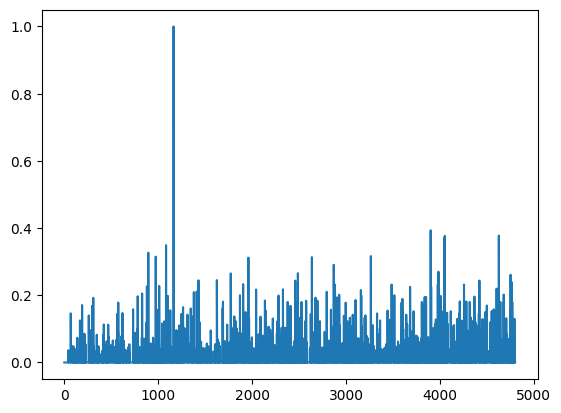

In [23]:
plt.plot(scores)

Now, we need the most similar scores, that is the largest values of similarity scores.
So we need to sort to sort them in descending order, 

 To make things simpler, can use argsort() function, which orders a given set of elements, but reports the result indirectly usingthe existing manner of indexes.

In this case, it will return the dataframe index of the movies in descending order of the movies's similarity scores.

(-scores) is used to get the elements such that argsort(), which sorts in ascending order, will actually sort the scores in 
descending order.

In [24]:
result_scores =(-scores).argsort()

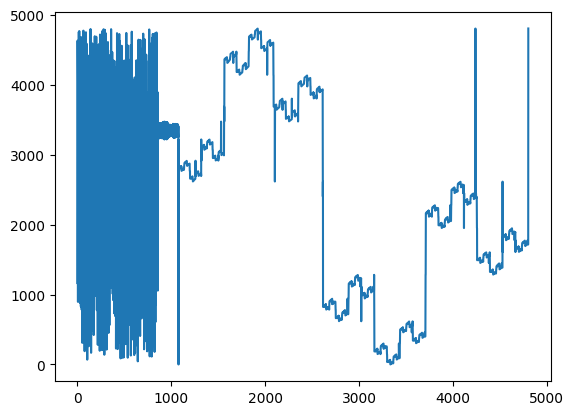

In [25]:
plt.plot((-scores).argsort())

Now that we have obtained the scores in descending order, we need to extract the top 5 scores of the movies.
We have to ignore the first value, since the query movie will have the highest similairty score for itself.


In [26]:
result_indices= result_scores[1:6]

And now to extract the corresponding movie titles for the indexes,

In [27]:
recd_movies=moviedata['title'].iloc[result_indices]
recd_movies

3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object

Thus, from a query, we have obtained the 5 most similar movies.

To implement the entire process as a function :

In [32]:
def get_recommendations(movie):
    idX=find_index(movie)
    if type(idX) == pd.Series:
        idX=idX.iloc[0]
    result= (-(cosine_similarity(M1[idX],M1).flatten())).argsort()[1:6]
    print(moviedata['title'].iloc[result])
    
    
    

For example :

In [33]:
quer=input("Enter movie :")

print(get_recommendations(quer))

Enter movie :Fury
586                  The Monuments Men
3516                         The Train
1787                  A Bridge Too Far
4465               Saints and Soldiers
2798    The Boy in the Striped Pyjamas
Name: title, dtype: object
None
